# Summarising the variance of Gaussian noise

Tom Charnock

Institut d'Astrophysique de Paris
<br><br><br>


<table style="width:100%;" border="0">
    <tr style="background-color:white;"><td>
        <img src="IMNN/SU.jpeg" alt="Sorbonne Université" style="height: 80px;"/>
    </td><td>
        <img src="IMNN/ANR.png" alt="ANR" style="height: 100px;"/>
    </td><td>
        <img src="IMNN/IAP.jpeg" alt="IAP" style="height: 100px;"/>
    </td><td>
        <img src="IMNN/CNRS.jpeg" alt="CNRS" style="height: 100px;"/>
    </td><td>
        <img src="IMNN/Aquila.png" alt="Aquila" style="height: 100px;"/>
    </td></tr>
</table>

We're going to use a neural network to find the optimal summary of the variance of some Gaussian noise. The likelihood of the data is non-Gaussian and is described by
$$-2\ln\mathcal{L}({\bf d}|\Sigma)=\frac{1}{\Sigma}\sum_i^{n_d}d_i^2+n_d\ln[2\pi\Sigma]$$
This is an interesting problem since we know the true optimal sufficient statistic
$$t = \sum_i^{n_d} d_i^2.$$
This summary is a non-linear function (squaring) of the data. Linear compression can therefore not provide an optimal summary. Let's see if the IMNN can find this.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf

We define a simulator of the random noise - its just a fancy wrapper around np.random.normal()

In [10]:
def simulator(θ, seed, simulator_args):
    if seed is not None:
        np.random.seed(seed)
    return np.moveaxis(np.random.normal([0 for i in range(θ.shape[0])], np.sqrt(θ[:, 0]), simulator_args["input shape"] + [θ.shape[0]]), -1, 0)

We also want a function to create all the data we want for training - we'll run this soon!

In [17]:
def generate_data(n_train, num_sims, num_partial_sims, input_shape, θ, h, seed):
    t = simulator(θ = np.tile(θ, [n_train * num_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})
    t = np.concatenate([t, simulator(θ = np.tile(θ, [n_train * (num_sims - num_partial_sims), 1]), seed = seed + 1, simulator_args = {"input shape": input_shape})])
    t_m = simulator(θ = np.tile(θ - np.array(h), [n_train * num_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})
    t_p = simulator(θ = np.tile(θ + np.array(h), [n_train * num_partial_sims, 1]), seed = seed, simulator_args = {"input shape": input_shape})
    t_d = ((t_p - t_m) / (2. * h[0]))[:, np.newaxis, :]
    data = {"data": t, "data_d": t_d}
    tt = simulator(θ = np.tile(θ, [num_partial_sims, 1]), seed = seed + 2, simulator_args = {"input shape": input_shape})
    tt = np.concatenate([tt, simulator(θ = np.tile(θ, [(num_sims - num_partial_sims), 1]), seed = seed + 3, simulator_args = {"input shape": input_shape})])
    tt_m = simulator(θ = np.tile(θ - np.array(h), [num_partial_sims, 1]), seed = seed + 2, simulator_args = {"input shape": input_shape})
    tt_p = simulator(θ = np.tile(θ + np.array(h), [num_partial_sims, 1]), seed = seed + 2, simulator_args = {"input shape": input_shape})
    tt_d = ((tt_p - tt_m) / (2. * h[0]))[:, np.newaxis, :]
    data["validation_data"] = tt
    data["validation_data_d"] = tt_d
    np.random.seed()
    return data

We will also also want to see what were doing, so here are some plotting functions

In [18]:
def plot_real_data(data):
    fig, ax = plt.subplots(1, 1, figsize = (8, 6))
    ax.plot(real_data[0], label = "observed data")
    ax.legend(frameon = False)
    ax.set_xlim([0, 9])
    ax.set_xticks([])
    ax.set_ylabel("${\\bf d}$");

In [19]:
def plot_data(data):
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    ind = np.random.randint(data["data_d"].shape[0])
    validation_ind = np.random.randint(data["validation_data_d"].shape[0])
    ax[0].plot(data['data'][ind], label = "training data")
    ax[0].plot(data['validation_data'][validation_ind], label = "test data")
    ax[0].legend(frameon = False)
    ax[0].set_xlim([0, 9])
    ax[0].set_xticks([])
    ax[0].set_ylabel("${\\bf d}$")
    ax[1].plot(data['data_d'][ind, 0], label = "training data")
    ax[1].plot(data['validation_data_d'][validation_ind, 0], label = "test data")
    ax[1].legend(frameon = False)
    ax[1].set_xlim([0, 9])
    ax[1].set_xticks([])
    ax[1].set_ylabel("$\partial{\\bf d}/\partial\Sigma$");

In [20]:
def plot_loss(history):
    fig, ax = plt.subplots(2, 1, sharex = True, figsize = (8, 8))
    plt.subplots_adjust(hspace = 0)
    epochs = np.arange(1, len(history["det F"]) + 1)
    ax[0].plot(epochs, history["loss"], label = 'loss from training data')
    ax[0].plot(epochs, history["test loss"], label = 'loss from validation data')
    ax[0].legend(frameon = False)
    ax[0].set_xlim([1, epochs[-1]])
    ax[0].set_ylabel(r"$loss$")
    ax[1].plot(epochs, history["det F"], label = r'$|{\bf F}_{\alpha\beta}|$ from training data')
    ax[1].plot(epochs, history["det test F"], label = r'$|{\bf F}_{\alpha\beta}|$ from validation data')
    ax[1].legend(frameon = False)
    ax[1].axhline(5, color = "black", linestyle = "dashed")
    ax[1].set_xlim([1, epochs[-1]])
    ax[1].set_ylabel(r"$|{\bf F}_{\alpha\beta}|$")
    ax[1].set_xlabel("Number of epochs");

In [21]:
def plot_abc(real_data, abc):
    Σ_array = np.linspace(0.001, 10, 1000)
    dx = (Σ_array[1] - Σ_array[0])

    analytic_posterior = np.exp(-0.5 * (np.sum((real_data[0])**2., axis = 0) / Σ_array + real_data.shape[1] * np.log(2. * np.pi * Σ_array)))
    analytic_posterior = analytic_posterior / np.sum(analytic_posterior * dx)
    
    gaussian_approximation, grid = abc.gaussian_approximation(gridsize = 1000)
    
    ϵ = 1.
    accept_indices = np.argwhere(abc.ABC_dict["distances"] < ϵ)[:, 0]
    reject_indices = np.argwhere(abc.ABC_dict["distances"] >= ϵ)[:, 0]
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 6))
    plt.subplots_adjust(wspace = 0, hspace = 0)
    ax.plot(Σ_array, analytic_posterior, linewidth = 1.5, color = 'C2', label = "Analytic posterior")
    ax.plot(grid[0], gaussian_approximation, color = "C1", label = "Gaussian approximation")
    ax.hist(abc.ABC_dict["parameters"][accept_indices], np.linspace(0, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = "C6", label = "ABC posterior");
    ax.hist(abc.PMC_dict["parameters"], np.linspace(0, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = "C4", label = "PMC posterior");
    ax.legend(frameon = False)
    ax.set_xlim([0, 10])
    ax.set_xlabel("$\\Sigma$")
    ax.set_ylabel("$\\mathcal{P}(\\Sigma|{\\bf d})$")
    ax.set_yticks([]);

And because this is a machine learning task, here's a function which makes a dense layer...

In [22]:
def dense(x, nodes, name):
    input_shape = x.get_shape().as_list()[-1]
    w = tf.get_variable(dtype = tf.float32, shape = (input_shape + 1, nodes), name = name + "/w")
    y = tf.concat([x, tf.ones([tf.shape(x)[0], 1])], axis = 1)
    return tf.matmul(y, w)

# Lets make some data!

We're going to make some Gaussian data with $n_{\bf d}=10$ data points and variance $\Sigma = 1$. This is going to be our _real_ data.

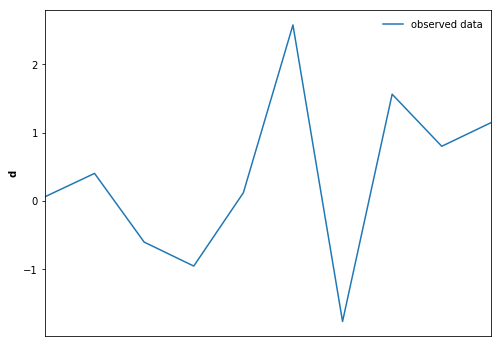

In [23]:
real_data = simulator(np.array([[1.]]), np.random.randint(int(1e6)), {"input shape": [10]})
plot_real_data(real_data)

The true value of the variance of this _real_ data is

In [24]:
print("The variance of this real data is", np.std(real_data)**2.)

The variance of this real data is 1.4526545184229904


## Informative compressed summaries

The information inequality provides a natural description of
### <center>optimal compressed summaries</center>

We define optimal statistics as the set of summaries which saturate the information inequality

$$Cov\left[{\bf x}_\alpha,{\bf x}_\beta\right] \ge \frac{\partial\langle{\bf x}_\mu\rangle}{\partial\theta_\alpha} {\bf F}^{-1}_{\mu\nu}\frac{\partial\langle{\bf x}_\nu\rangle}{\partial\theta_\beta}$$

## Fisher information

Amount of information some data, ${\bf d}$, contains about model parameters, $\boldsymbol{\theta}$, with likelihood $\mathcal{L}({\bf d}|\boldsymbol{\theta})$
 
$$\begin{align*}
    {\bf F}_{\alpha\beta} & = - \left.\left\langle\frac{\partial^2\ln\mathcal{L}({\bf d}|\boldsymbol{\theta})}{\partial\theta_\alpha\partial\theta_\beta}\right\rangle\right|_{\boldsymbol{\theta}^\textrm{fid}}\\
    & = \phantom{-}\left.\left\langle\frac{\partial\ln\mathcal{L}({\bf d}|\boldsymbol{\theta})}{\partial\theta_\alpha}\frac{\partial\ln\mathcal{L}({\bf d}|\boldsymbol{\theta})}{\partial\theta_\beta}\right\rangle\right|_{\boldsymbol{\theta}^\textrm{fid}}
\end{align*}$$

#### Expectation of the square of the score function at some fiducial model parameter values

##  How to build optimal compressed summaries

Start by expanding a generalised log-likelihood about some fiducial parameters, $\boldsymbol{\theta}^\textsf{fid}$
$$\begin{align*}
    \ln\mathcal{L}({\bf d}|\boldsymbol{\theta})\phantom{+} =&\phantom{+} \ln\mathcal{L}({\bf d}|\boldsymbol{\theta}^\textrm{fid})+\delta\theta_\alpha^T\frac{\partial\ln\mathcal{L}({\bf d}|\boldsymbol{\theta}^\textrm{fid})}{\partial\theta_\alpha}\\
    &\phantom{+}+\frac{1}{2}\delta\theta_\alpha^T\frac{\partial^2\ln\mathcal{L}({\bf d}|\boldsymbol{\theta}^\textrm{fid})}{\partial\theta_\alpha\partial\theta_\beta}\delta\theta_\beta + \cdots
\end{align*}$$

To linear order, the data only couples to the log-likelihood through the score fuction at some fiducial parameters

## Use the score function as a set of summaries

$${\bf x}_\alpha = \frac{\partial\ln\mathcal{L}({\bf d}|\boldsymbol{\theta}^\textrm{fid})} {\partial\theta_\alpha}$$

This is a set of _sufficient_* statistics which saturate the information inequality

$$Cov\left[{\bf x}_\alpha,{\bf x}_\beta\right] = \frac{\partial\langle{\bf x}_\mu\rangle}{\partial\theta_\alpha}{\bf F}^{-1}_{\mu\nu}\frac{\partial\langle{\bf x}_\nu\rangle}{\partial\theta_\beta}$$

Since gradient of the expectation value of the summaries (evaluated at the fiducial parameter values) is

$$\begin{align*}
    \frac{\partial\langle{\bf x}_\beta\rangle}{\partial\theta_\alpha}= & \phantom{=}\left.\left\langle\frac{\partial^2\ln\mathcal{L}({\bf d}|\boldsymbol{\theta})}{\partial\theta_\alpha\partial\theta_\beta}\right\rangle\right|_{\boldsymbol{\theta}^\textrm{fid}}\\
   = & \phantom{=}-{\bf F}_{\alpha\beta}
\end{align*}$$

such that

$$\frac{\partial\langle{\bf x}_\mu\rangle}{\partial\theta_\alpha}{\bf F}^{-1}_{\mu\nu}\frac{\partial\langle{\bf x}_\nu\rangle}{\partial\theta_\beta} = {\bf F}_{\alpha\beta}$$

and the covariance of the summaries is

$$\begin{align*}
    Cov\left[{\bf x}_\alpha, {\bf x}_\beta\right] = & \left.\left\langle\frac{\partial\ln\mathcal{L}({\bf d}|\boldsymbol{\theta})}{\partial\theta_\alpha}\frac{\partial\ln\mathcal{L}({\bf d}|\boldsymbol{\theta})}{\partial\theta_\beta}\right\rangle\right|_{\boldsymbol{\theta}^\textrm{fid}}\\
    =& {\bf F}_{\alpha\beta}
\end{align*}$$

then ${\bf x}_\alpha$ saturate the information inequality

$$Cov\left[{\bf x}_\alpha,{\bf x}_\beta\right] = \frac{\partial\langle{\bf x}_\mu\rangle}{\partial\theta_\alpha}{\bf F}^{-1}_{\mu\nu}\frac{\partial\langle{\bf x}_\nu\rangle}{\partial\theta_\beta}$$

## The score function defines _optimal_ compressed summaries

## Informative compressed summaries

**MASSIVE** dimensionality compression

$$\mathbb{R}^{n_{\bf d}}\to\mathbb{R}^{n_\textrm{params}}$$

We just need to know how to take the partial derivative of the log-likelihood

$${\bf x}_\alpha = \frac{\partial\ln\mathcal{L}({\bf d}|\boldsymbol{\theta}^\textrm{fid})}{\partial\theta_\alpha}$$

## We can try and approximate the likelihood

If the likelihood of our data is Gaussian:

<center>this problem is solved with lossless summaries<br>this is MOPED compression</center>

If our likelihood is known to linear order:

<center>this problem is solved with lossless summaries</center>

If the likelihood of our data is nearly-Gaussian:

<center>this problem is basically solved with not-quite-lossless summaries</center>

If our data has known useful summaries
<br>(for example the power spectrum):
<br><br>
<center>we can compress the data to the useful summaries<br>then compress the summaries using score compression</center>

<img style="max-width:70%;max-height:70%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/2_stage_compression.png">

# Information maximising neural networks

### Load the (very easy to use) module

In [25]:
%pip install IMNN

Note: you may need to restart the kernel to use updated packages.


or
<a href="https://github.com/tomcharnock/IMNN">github.com/tomcharnock/IMNN</a>

In [26]:
from IMNN import IMNN

## Find the function which gives Gaussian summaries

We find a way to map the data to some summaries $\mathscr{f}:{\bf d}\to{\bf x}$, where ${\bf x}$ are described by

$$-2\ln\mathcal{L}({\bf x}|\boldsymbol{\theta}) = ({\bf x}-\mu_\mathscr{f}(\boldsymbol{\theta}))^T{\bf C}^{-1}_\mathscr{f}({\bf x}-\mu_\mathscr{f}(\boldsymbol{\theta}))$$

where $\mu_\mathscr{f}(\boldsymbol{\theta})$ and ${\bf C}_\mathscr{f}$ are the mean and covariance an ensemble of summaries mapped from fiducial simulations.

## This function is a trained neural network

### <center>optimised to maximise the Fisher information!</center>

$$\textsf{Loss} = -\ln\det{\bf F}_{\alpha\beta} + \lambda||{\bf C}_\mathscr{f}-\mathbb{I}||_2$$

## Fisher information given our _known_ Gaussian likelihood of summaries

$${\bf F}_{\alpha\beta} = \frac{\partial\mu_\mathscr{f}}{\partial\theta_\alpha}^T{\bf C}_\mathscr{f}^{-1}\frac{\partial\mu_\mathscr{f}}{\partial\theta_\beta}$$

# Training the network

## Build the network to best exploit the data

Fully connected networks when you don't know better
<br>(oddly distributed data)

<img style="max-width:50%;max-height:50%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/neural_network.png">

Convolutions for translationally invariant data<br>
(images or local signals)

<img style="max-width:80%;max-height:80%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/convolutional_network.png">

Other specialised architectures<br>
(spherical convolutional networks for cosmological maps)

<img style="max-width:80%;max-height:80%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/spherical_convolutional_network.png">

## We can build the network to work on summaries with unknown likelihoods

<img style="max-width:100%;max-height:80%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/2_stage_non_linear_compression.png">

## Finding that _one_ extra summary...

We can combine the IMNN with our known and loved summaries to extract just that little bit extra information

<img style="max-width:80%;max-height:80%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/spherical_convolutional_network_additional.png">

## Of course we can still do score compression

<img style="max-width:80%;max-height:80%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/spherical_convolutional_network_additional_score.png">

# Define our network

So let's actually get to work on our variance summarising network...

We're going to build a fully connected neural network with two dense layers with 128 neurons in each, activated using `Leaky ReLU` with $\alpha=0.01$. Okay, this isn't the network built explicitly for this data - but it's going to work ;-)

<img style="max-width:50%;max-height:50%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/neural_network.png">

In [27]:
def network(input_tensor):
    x = tf.nn.leaky_relu(dense(input_tensor, 128, "layer_1"), 0.01)
    x = tf.nn.leaky_relu(dense(x, 128, "layer_2"), 0.01)
    return dense(x, imnn.n_summaries, "output")

## Generate training (and validation) data

### Massively cheap

We only need simulations at the fiducial parameter values! We're going to make 1000 simulations for training (and 1000 for validation) and a further 100 simulations to calculate the numerical derivative. We are choosing a fiducial variance of 1.

In [28]:
n_s = 1000
n_p = 100
n_train = 1
num_summaries = 1
fiducial = [1.]
h = [0.1]
input_shape = [10]

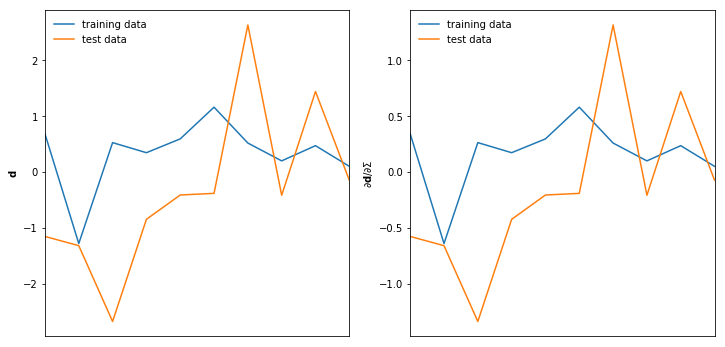

In [29]:
data = generate_data(n_train, n_s, n_p, input_shape, fiducial, h, np.random.randint(int(1e6)))
plot_data(data)

## Let's build the IMNN

In [30]:
imnn = IMNN.IMNN(
    {"number of simulations": n_s,
     "number of derivative simulations": n_p,
     "fiducial": fiducial,
     "number of summaries": num_summaries,
     "input shape": input_shape,
     "dtype": 32})

In [31]:
imnn.setup(network = network, load_data = data)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Pass $n_\textrm{sims}$ simulations through the network and calculate ${\bf C}_\mathscr{f}$

<img style="max-width:80%;max-height:70%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/covariance.png">

## Calculate the derivative of the network outputs with respect to the parameters 
$$\frac{\partial\mu_\mathscr{f}}{\partial\theta_\alpha} = \frac{1}{n_\textrm{p}}\sum_{i=1}^{n_\textrm{p}}\frac{\partial{\bf x}_i}{\partial{\bf d}_i}\frac{\partial{\bf d}_i}{\partial\theta_\alpha}$$

## Calculate the Fisher information

$${\bf F}_{\alpha\beta} = \frac{\partial\mu_\mathscr{f}}{\partial\theta_\alpha}^T{\bf C}_\mathscr{f}^{-1}\frac{\partial\mu_\mathscr{f}}{\partial\theta_\beta}$$

## Update the network parameters using the gradient of the loss function

$$\textsf{Loss} = -\ln\det{\bf F}_{\alpha\beta} + \lambda||{\bf C}_\mathscr{f}-\mathbb{I}||_2$$

<img style="max-width:60%;max-height:60%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/neural_network.png">


# Lather, rince, repeat...

Lets do it!

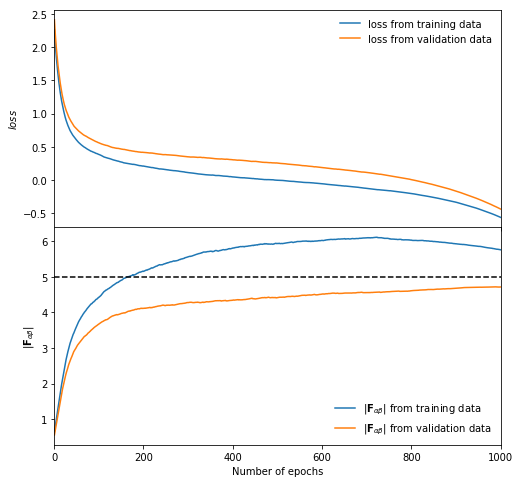

In [32]:
imnn.train(updates = 1000, at_once = n_s, learning_rate = 1e-3,
        constraint_strength = 2.)
plot_loss(imnn.history)

The optimal statistics would be obtained when the orange (validation) set reaches the dotted black line.

You might end up with more information being pulled from the training set, in which case your covariance is skewed by not having enough training data and you probably should use more training data.

Even if the orange curve is below the dotted line you should carry on below - we can see how a suboptimally trained network can still give us correct (if inflated) posteriors!

# Inference time!

We get a Gaussian approximation of the posterior directly from the IMNN with no extra simulations. This is done by getting the maximum likelihood estimate of the variance and using the square root of the inverse Fisher information as the forecasts of the variance of the distribution. A plot of this is available by running
```python
gaussian_approximation, grid = abc.gaussian_approximation(gridsize = 1000)
```

We can use the handy ABC module inside the IMNN to do ABC or more advanced ABC. The naïve ABC draws samples from the joint space of data (summaries) and parameter values and acception and reject of samples is based on the distance of the summary of the simulations from the summary of the real data. Because we'll never hit the data exactly we choose a small ε where we accept samples. We can actually learn this ε using population statistics, this is known as population Monte Carlo ABC (PMC-ABC). This is also implemented in the IMNN module.
<br><br>
<img style="max-width:60%;max-height:60%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/ABC.png">


In [33]:
from IMNN.ABC import ABC 
from IMNN.ABC import priors

prior = priors.TruncatedGaussian(np.array([1.]), np.array([[10.]]), 
                                 np.array([0.]), np.array([10.]))
abc = ABC.ABC(real_data=real_data, prior=prior, sess=imnn.sess, 
              get_compressor=imnn.get_compressor, 
              simulator=simulator, 
              simulator_args={"input shape": input_shape},
              seed=None)

abc.ABC(draws=100000)

abc.PMC(draws=1000, posterior=1000, criterion=0.1) 

### How did we do (fingers crossed)

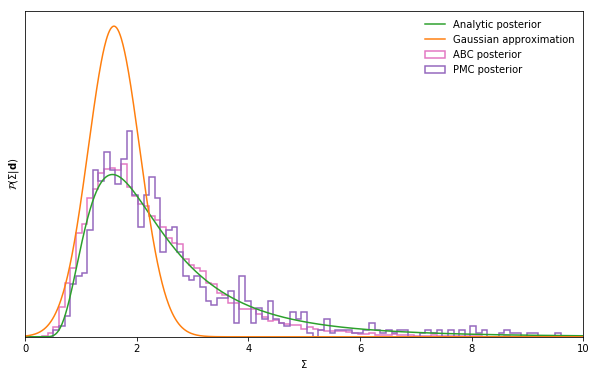

In [34]:
plot_abc(real_data, abc)

Is the purple histogram like the green analytic curve?

# Out of interest - here are some more examples


## Infering the ionisation rate from quasar absorption spectra

<img style="max-width:70%;max-height:70%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/flux_train.png">

## Use fully connected neural network

<img style="max-width:60%;max-height:60%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/neural_network.png">

## Couple it with DELFI to get convincing posterior!

<img style="max-width:80%;max-height:80%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/imnn_gamma.png">

## Multi-dimensional cosmological parameter inference from cosmic sheap maps of a Euclid-like survey

<img style="max-width:80%;max-height:80%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/shear_data.png">

## Summarise the maps via the power spectrum and compress that with the IMNN

<img style="max-width:100%;max-height:80%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/2_stage_non_linear_compression.png"> 

### Use DELFI for inference

<img style="max-width:50%;max-height:50%;display:block;height:auto;margin:auto;float:none!important;" src="IMNN/IMNN_Euclid_shear.png">

# Download IMNN now!

```python
pip install IMNN
```

<a href="https://github.com/tomcharnock/IMNN.git">github.com/tomcharnock/IMNN</a>